## **Fig3g** ##

In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

import argparse
import random
import networkx as nx

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from ignite.engine import Engine, Events
#from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

method = ''
from g2g_model_Fisher import *

## **Data overview** ##

In [2]:
data_path = 'data/'
# data_name = 'DG_bin_ppt'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [10, 3, 6]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'RC_action_results_0617modified/'+data_name+'P2M,'+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = result_path
encoder_path = 'main_results/'+'zebrafish_dynamo_part'+' '+str([k_nei,K,L])+'/'
cmap = plt.colormaps['Spectral']

t_list=np.array(['Proliferating Progenitor', 'Pigment Progenitor', 'Melanophore'])

In [3]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

folder = os.path.exists(figure_path)
if not folder:
    os.makedirs(figure_path)

In [4]:
from scipy.sparse import csr_matrix
import scanpy as sc
adata = adata0.copy()
sc.pp.pca(adata, n_comps=pca_dim)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=pca_dim, n_neighbors=k_nei)
scv.tl.velocity(adata)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
Xs = adata.layers['Ms'] #adata.X.A#
# Xs = adata.layers['M_s'] #如果是EG_ab_dyn
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])
cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei-1])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)


#################################################
#################################################
encoder = torch.load(encoder_path+'encoder.pt')


mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

cRc_arr=[]
cRc_arr_eu=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [5]:
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = velo_g@adata.varm['PCs']
latent_z = np.hstack((mu_learned,sigma_learned))

In [6]:
X_plt = X_umap[:,0]
Y_plt = X_umap[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min-wid*10

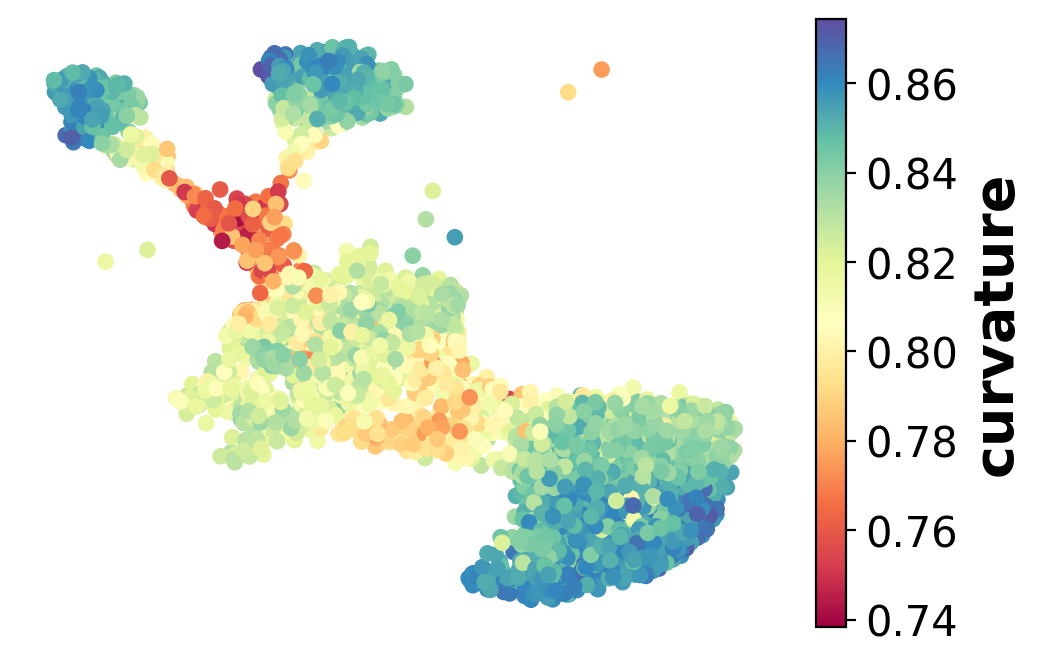

In [7]:
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

## **Average Path** ##

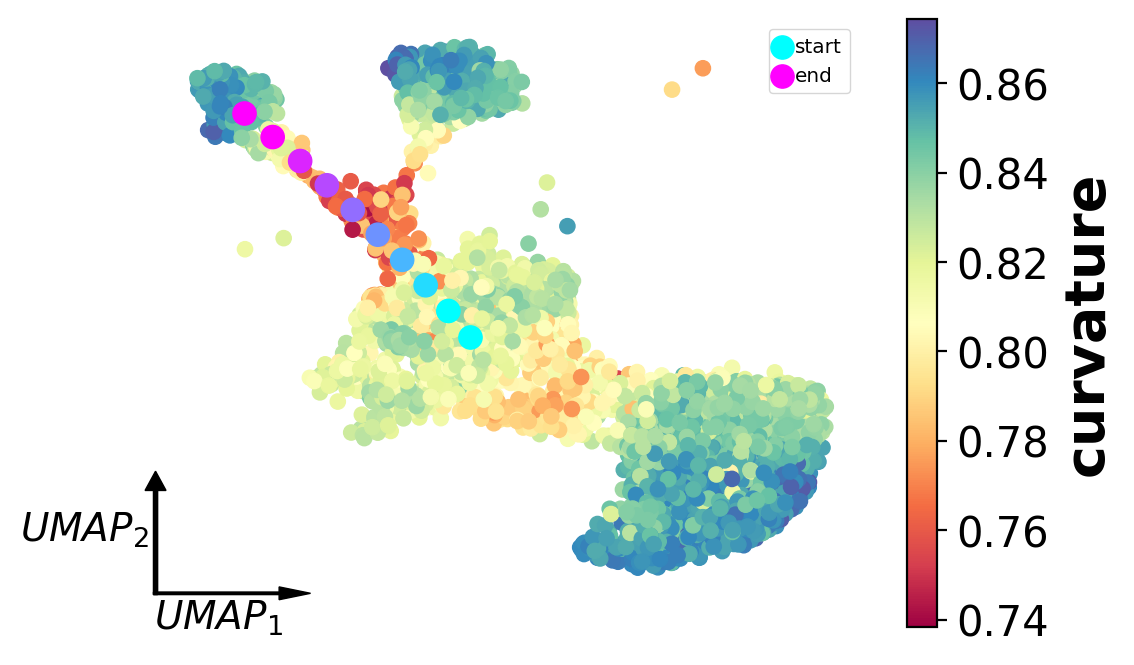

In [8]:
# average_path = np.load(result_path+'zebrafish_P2M_rc.npy')

# average_path[:, 1] = average_path[:, 1]
# # Plotting the average path
# idx = ~np.isnan(crc_smooth)
# cmap = plt.colormaps['Spectral']
# plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
# clb=plt.colorbar()
# clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
# clb.ax.tick_params(axis='y', labelsize=15)
# # plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')
# plt.axis('off')
# plt.scatter(average_path[:,0],average_path[:,1],c='purple', linewidth=2, label='RC path')
# plt.scatter(average_path[0,0],average_path[0,1],c='red', linewidth=2, label='Start')
# plt.scatter(average_path[-1,0],average_path[-1,1],c='blue', linewidth=2, label='End')
# # plt.scatter(X_plt[average_path[0]],Y_plt[average_path[0]], color='red', s=50, label='Start')
# # plt.scatter(X_plt[average_path[-1]],Y_plt[average_path[-1]], color='blue', s=50, label='End')
# plt.legend(loc = 'best')



# plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
# plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
# plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
# plt.text(X_ori-wid*17,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

# plt.savefig(result_path+'path.png')

# 加载数据
average_path = np.load('zebrafish_P2M_rc.npy')

# 绘制曲率背景
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx], Y_plt[idx], c=crc_smooth[idx], s=30, cmap=cmap)
clb = plt.colorbar()
clb.ax.set_ylabel('curvature', fontsize=20, weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
plt.axis('off')

# 绘制渐变色路径
n_points = len(average_path)
colors = np.linspace(0, 1, n_points)
plt.scatter(average_path[1:-1, 0], average_path[1:-1, 1],
            c=colors[1:-1], cmap='cool', s=70)

cool_cmap = plt.cm.get_cmap('cool')

# 提取两端颜色（0表示左端，1表示右端）
start_end_color = cool_cmap((0,255))     # RGBA格式


# 绘制起始点（带start标签）
plt.scatter(average_path[0:1, 0], average_path[0:1, 1],
            c=start_end_color[0], s=70, label='start')

# 绘制终点（带end标签）
plt.scatter(average_path[-1:, 0], average_path[-1:, 1],
            c=start_end_color[1], s=70, label='end')

# 坐标轴箭头和标签（保持原代码）
plt.arrow(X_ori - wid / 2, Y_ori, X_len, 0, width=wid, color='black', head_width=5 * wid)
plt.arrow(X_ori, Y_ori - wid / 2, 0, Y_len, width=wid, color='black', head_width=5 * wid)
plt.text(X_ori + X_len / 2, Y_ori - wid * 14, '$UMAP_1$', fontsize=14, ha='center', weight='bold')
plt.text(X_ori - wid * 17, Y_ori + Y_len / 2, '$UMAP_2$', fontsize=14, ha='center', weight='bold')

# 保存图像
plt.legend(loc='best')
plt.savefig(result_path + 'path.png', dpi=600, bbox_inches='tight')
plt.show()

In [9]:
# # trans coordinates in average_path to nodes indices
# distances = np.linalg.norm(X_pca[:, np.newaxis,:] - average_path, axis=2)

# nearest_indices = np.argmin(distances, axis=0)

In [10]:
average_path.shape

(10, 2)

## **For each cell, find its nearest reaction coordinate** ##


In [11]:
# trans coordinates in average_path to nodes indices
# trans coordinates in average_path to nodes indices
distances = np.linalg.norm(X_umap[:, np.newaxis,:] - average_path[:,:], axis=2)

nearest_indices = np.argmin(distances, axis=0)

# cell_arr = [[] for i in range(average_path.shape[0])]
# for j in range(adata.shape[0]):
#     if adata.obs['Cell_type'][j] != 'Melanophore':

#         distances = np.linalg.norm(X_umap[j,:] - average_path, axis=1)
#         reaction_coordinate = np.argmin(distances, axis=0)
#         cell_arr[reaction_coordinate].append(j)

# for i in range(len(cell_arr)):
#     cell_arr[i] = np.array(cell_arr[i])

# mask = ~(np.array([len(cell_arr[i]) for i in range(len(cell_arr))]) == 0)
# average_path = average_path[mask,:]
# nearest_indices = nearest_indices[mask]

# cell_arr = [[] for i in range(average_path.shape[0])]
# for j in range(adata.shape[0]):
#     if adata.obs['Cell_type'][j] != 'Melanophore':
#         distances = np.linalg.norm(X_umap[j,:] - average_path, axis=1)
#         reaction_coordinate = np.argmin(distances, axis=0)
#         cell_arr[reaction_coordinate].append(j)

# for i in range(len(cell_arr)):
#     cell_arr[i] = np.array(cell_arr[i])

In [12]:
from scipy.spatial.distance import cdist

def find_nearest_indices(average_path, X_umap, k=50):
    """
    找到X_umap中距离average_path每个点最近的k个点的索引
    
    参数:
    average_path : np.ndarray, shape (n, d)
        路径点数组
    X_umap : np.ndarray, shape (m, d)
        待搜索的点集
    k : int, 默认50
        要找到的最近邻数量
    
    返回:
    cell_arr : list of lists
        每个元素是一个包含最近邻索引的列表
    """
    # 计算所有点对之间的距离矩阵
    distances = cdist(average_path, X_umap, 'euclidean')
    
    # 对每一行(即每个average_path点)的距离进行排序，获取前k个最小距离的索引
    nearest_indices = np.argsort(distances, axis=1)[:, :k]
    
    # 转换为列表的列表
    cell_arr = [row.tolist() for row in nearest_indices]
    
    return cell_arr

cell_arr = find_nearest_indices(average_path, X_umap, k=50)


## **Plot the FI and Velo along the path** ##

In [13]:
#------use a simple neural network to study dmu/dt and dsigma/dt
latent_z = np.hstack((mu_learned,sigma_learned))


model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(200):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()
        
Fisher_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    Fisher_pca[i] = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]

Z_velo = np.array([pZ_pX[i]@velo_pca[i] for i in range(X.shape[0])])

## **plot on eigengene** ##

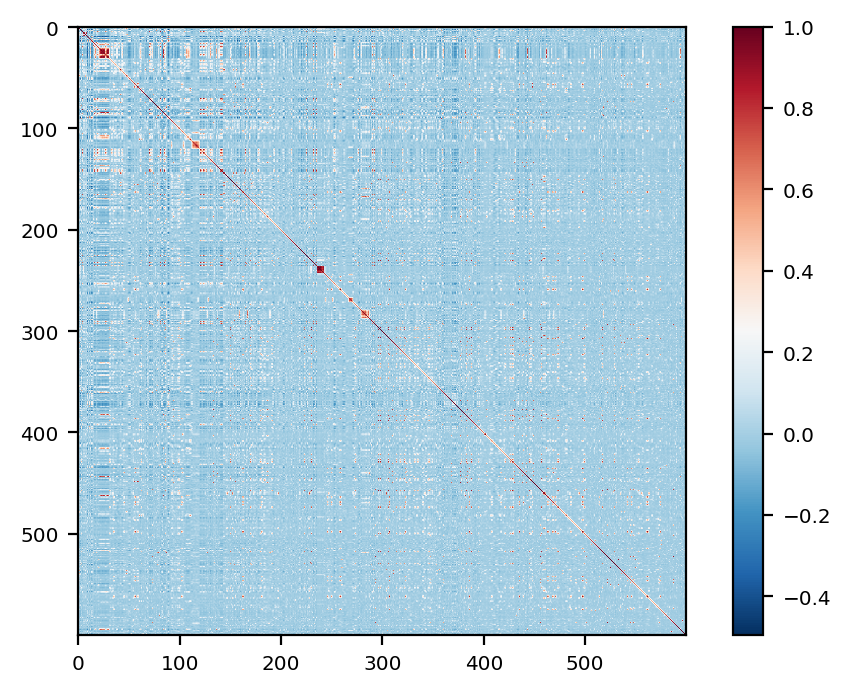

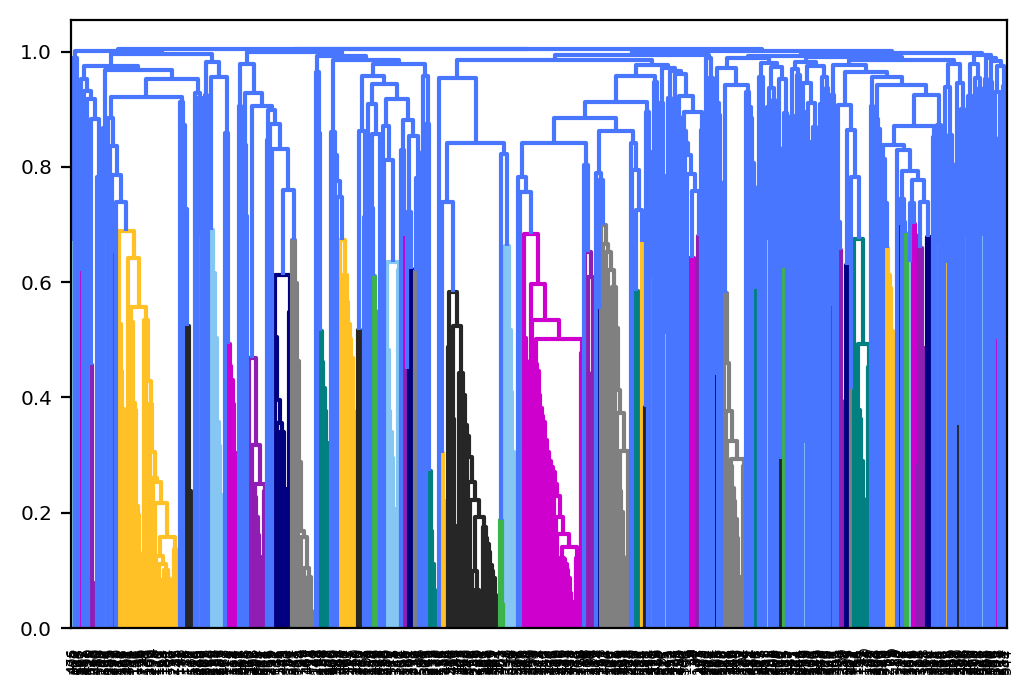

In [14]:
Xs = adata.layers['Ms']#adata.X.A#
Xu = adata.layers['Mu']
scaler = StandardScaler()#MinMaxScaler()#
X = scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()

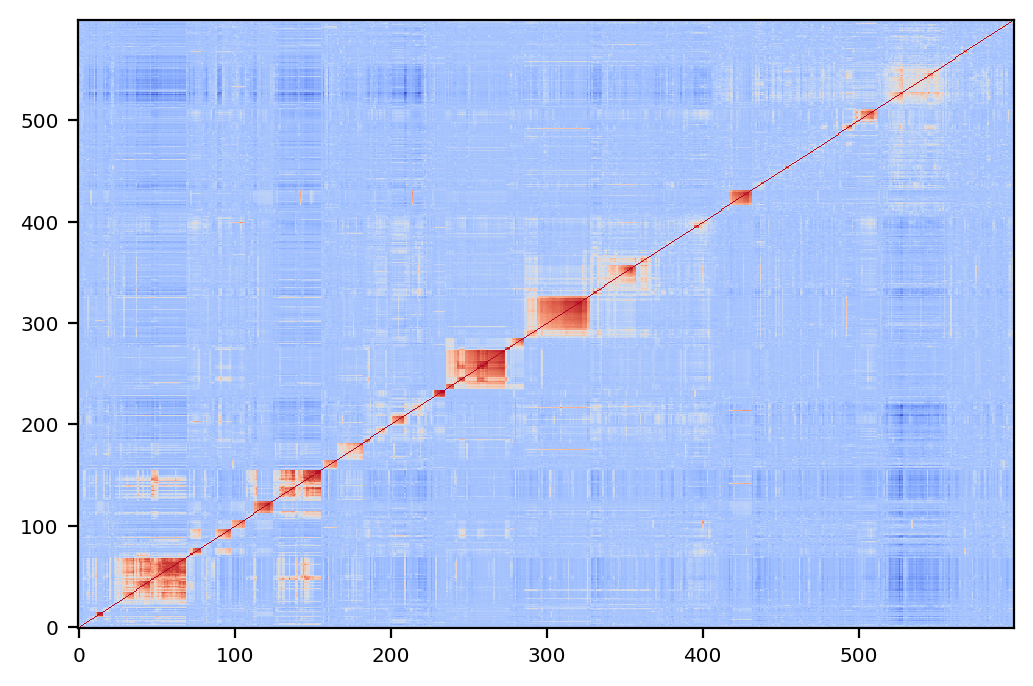

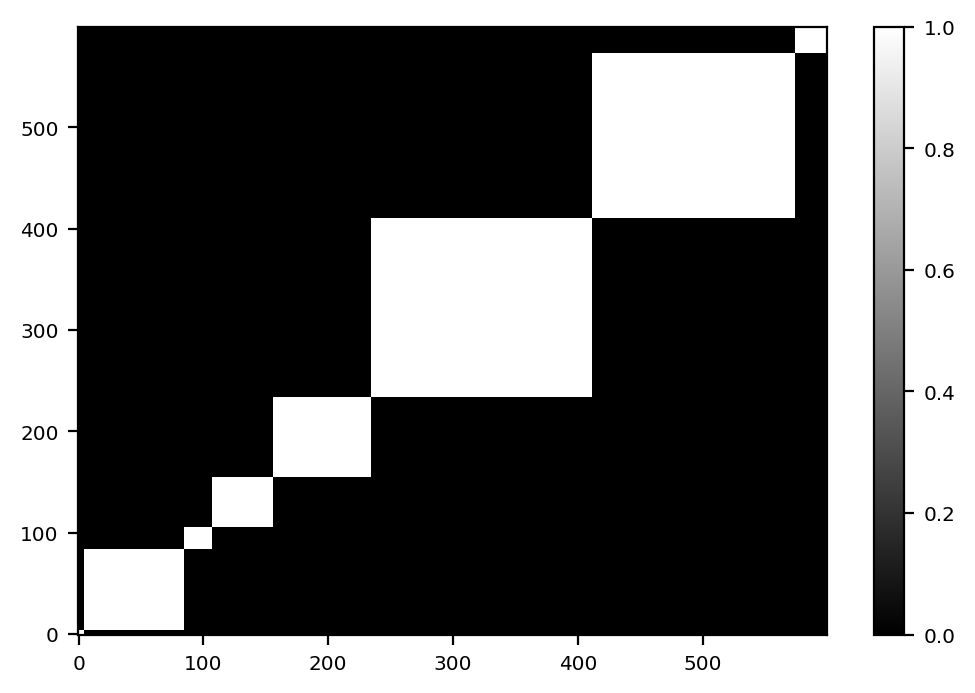

In [15]:
td = 0.996
T = fcluster(Z, t=td, criterion='distance')
# T=fcluster(Z, t=td, criterion='maxclust')
T_re = T[dg['leaves']]

plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.show()

X_corr_label = np.zeros(X_corr_re.shape)
for i in range(X_corr_re.shape[0]):
    label_ind = np.where(T_re==T_re[i])[0]
    X_corr_label[i,label_ind] = 1

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()

In [16]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        pca=PCA(n_components=5).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_.T)
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

In [17]:
eigen_X,eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))
print(eigen_dim)

[0.26855507 0.2521567  0.18962848 0.1600065  0.12965317]
[0.33716407 0.06532998 0.05336998 0.04321042 0.04138203]
[0.29809535 0.23236126 0.05969203 0.0446611  0.0426933 ]
[0.3722376  0.18652241 0.06305445 0.03557996 0.02800943]
[0.10113887 0.09372653 0.08256019 0.0695409  0.06072113]
[0.15375032 0.14268136 0.07945801 0.037899   0.03148644]
[0.08210205 0.06843358 0.04864821 0.03000546 0.02310194]
[0.07303751 0.06525949 0.05536512 0.05199574 0.0497648 ]
8


In [18]:
n_eigen = 1
cell_eigen_X = eigen_X[0,:,:n_eigen]
for i in range(eigen_dim-1):
    cell_eigen_X = np.hstack((cell_eigen_X,eigen_X[i+1,:,:n_eigen]))

In [19]:
from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_eigen_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.002, weight_decay=0.001)

x_in=torch.tensor(cell_eigen_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
    # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_pEg = np.zeros([cell_eigen_X.shape[0], L*2, cell_eigen_X.shape[1]])

# Compute the gradients
for i in range(cell_eigen_X.shape[0]):
    x0=torch.tensor(cell_eigen_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pEg[i,j,:] = x0.grad.detach()
print(pZ_pEg.shape)
print(loss_fn(model(x_in),x_out))

(3386, 12, 8)
tensor(0.7697, grad_fn=<MseLossBackward0>)


In [20]:
eigen_gij = np.zeros((X.shape[0],eigen_dim*n_eigen,eigen_dim*n_eigen))
for i in range(X.shape[0]):
    eigen_gij[i] = pZ_pEg[i].T @ Fisher_g[i] @ pZ_pEg[i]

In [21]:
X_standard = np.zeros(Xs.shape)
velo_standard = np.zeros(Xs.shape)
velo = velo_pca@adata.varm['PCs'].T
# velo = velo_pca@np.linalg.pinv(adata.varm['PCs'])
for j in range(Xs.shape[1]):
    X_mean = np.mean(Xs[:,j])
    X_std = np.std(Xs[:,j])
    X_standard[:,j] = (Xs[:,j]-X_mean)/X_std
    velo_standard[:,j] = velo[:,j]/X_std

In [22]:
velo_re = velo_standard[:,dg['leaves']]
velo_eigen = np.zeros(cell_eigen_X.shape) # eigen gene 上的速度分量
for i in range(eigen_dim):
    velo_eigen[:,i*n_eigen:(i+1)*n_eigen] = velo_re[:,T_re==i+1]@eigen_X_w[i][:,:n_eigen]

## **plot on hotspot** ##

In [23]:
import hotspot
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
hs = hotspot.Hotspot(
    adata, 
    model='danb',
    distances_obsp_key = 'distances'
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=k_nei,
)

hs_results = hs.compute_autocorrelations(jobs=1)

# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(800).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

modules = hs.create_modules(
    min_gene_threshold=10, core_only=True, fdr_threshold=0.1
)

modules.value_counts()
# np.save(result_path+'modules', modules.values)
# np.save(result_path+'hs_genes', hs_genes)

100%|██████████| 600/600 [00:00<00:00, 960.84it/s] 


Computing pair-wise local correlation on 302 features...


100%|██████████| 45451/45451 [00:02<00:00, 16380.93it/s]


Module
 3     47
-1     42
 5     39
 1     37
 2     35
 7     18
 6     16
 9     16
 10    15
 11    14
 8     12
 4     11
Name: count, dtype: int64

In [24]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        if i < 0:
            continue
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

In [25]:
adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module

scaler = StandardScaler()
X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
hs_X, hs_X_w = eigen_gene(X_hs,T_hs)
hs_dim=len(hs_X_w)
print(hs_dim)

[0.51506525 0.10410262]
[0.62205374 0.07454817]
[0.23605151 0.0797848 ]
[0.66393054 0.08162098]
[0.1724403  0.08481777]
[0.42787609 0.0900711 ]
[0.2806301  0.14544198]
[0.7325393  0.09394836]
[0.44432712 0.1310581 ]
[0.21024114 0.11194175]
[0.2206244  0.14293918]
11


In [26]:
cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
for j in range(X_hs.shape[0]):
    for k in range(len(hs_X_w)):
        cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])

In [27]:
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_hs_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(cell_hs_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_phs = np.zeros([cell_hs_X.shape[0], L*2, cell_hs_X.shape[1]])

# Compute the gradients
for i in range(cell_hs_X.shape[0]):
    x0=torch.tensor(cell_hs_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_phs[i,j,:] = x0.grad.detach()
print(pZ_phs.shape)

(3386, 12, 11)


In [28]:
Fisher_hs = np.zeros((X.shape[0],hs_dim, hs_dim))
for i in range(X.shape[0]):
    Fisher_hs[i] = pZ_phs[i].T@Fisher_g[i]@pZ_phs[i]

In [29]:
X_standard = np.zeros(adata_hs.layers['Ms'].shape)
velo_standard = np.zeros(adata_hs.layers['Ms'].shape)
velo = adata_hs.layers['velocity']
# velo = velo_pca@np.linalg.pinv(adata.varm['PCs'])
for j in range(adata_hs.layers['Ms'].shape[1]):
    X_mean = np.mean(adata_hs.layers['Ms'][:,j])
    X_std = np.std(adata_hs.layers['Ms'][:,j])
    X_standard[:,j] = (adata_hs.layers['Ms'][:,j]-X_mean)/X_std
    velo_standard[:,j] = velo[:,j]/X_std

In [30]:
velo_re = velo_standard
velo_eigen = np.zeros(cell_hs_X.shape) # hotspot gene 上的速度分量
for i in range(hs_dim):
    velo_eigen[:,i] = velo_re[:,T_hs==i+1]@hs_X_w[i][:]

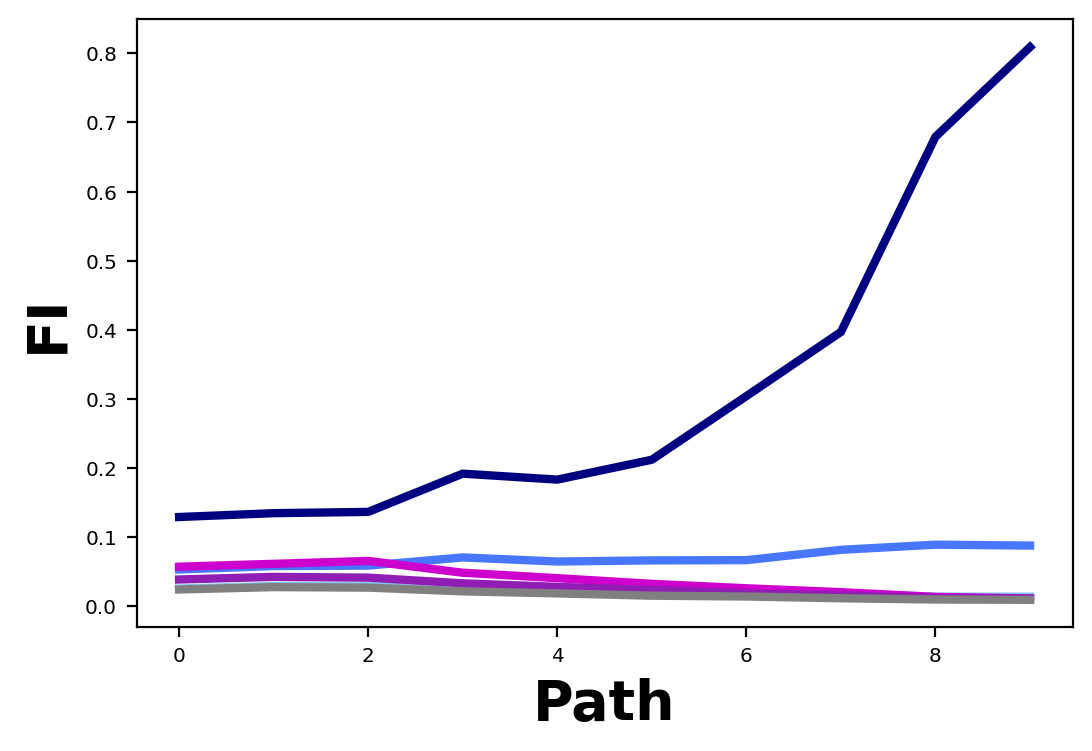

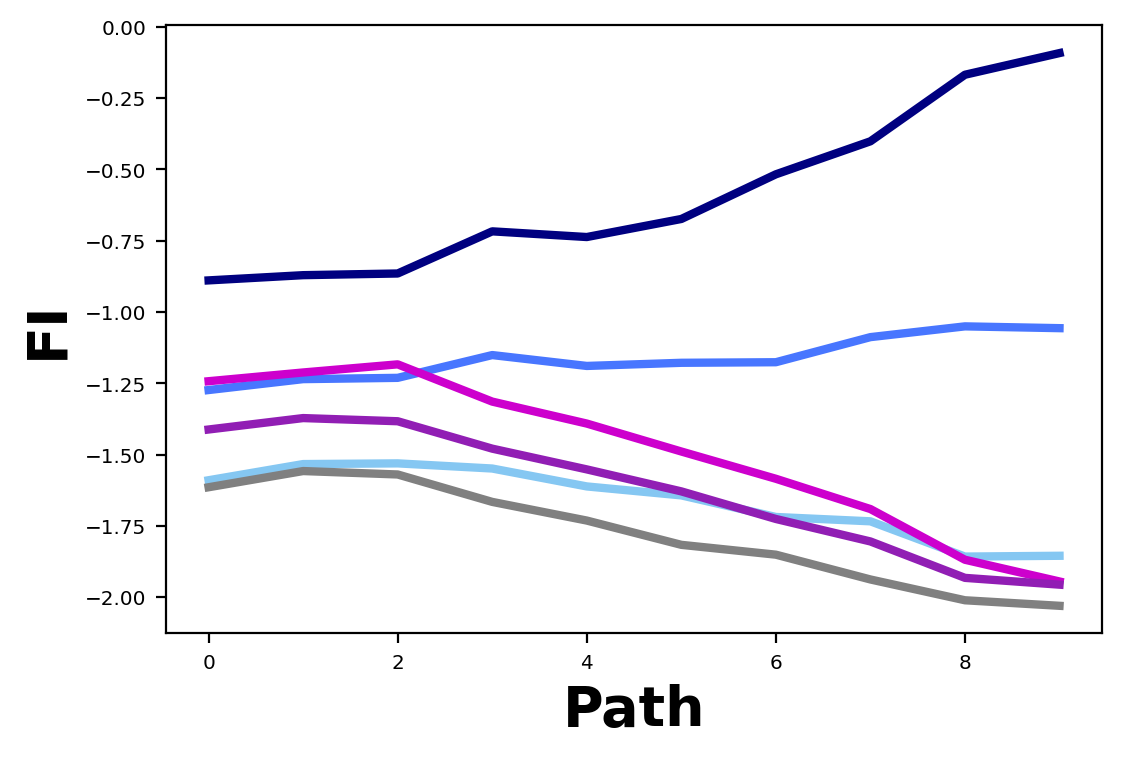

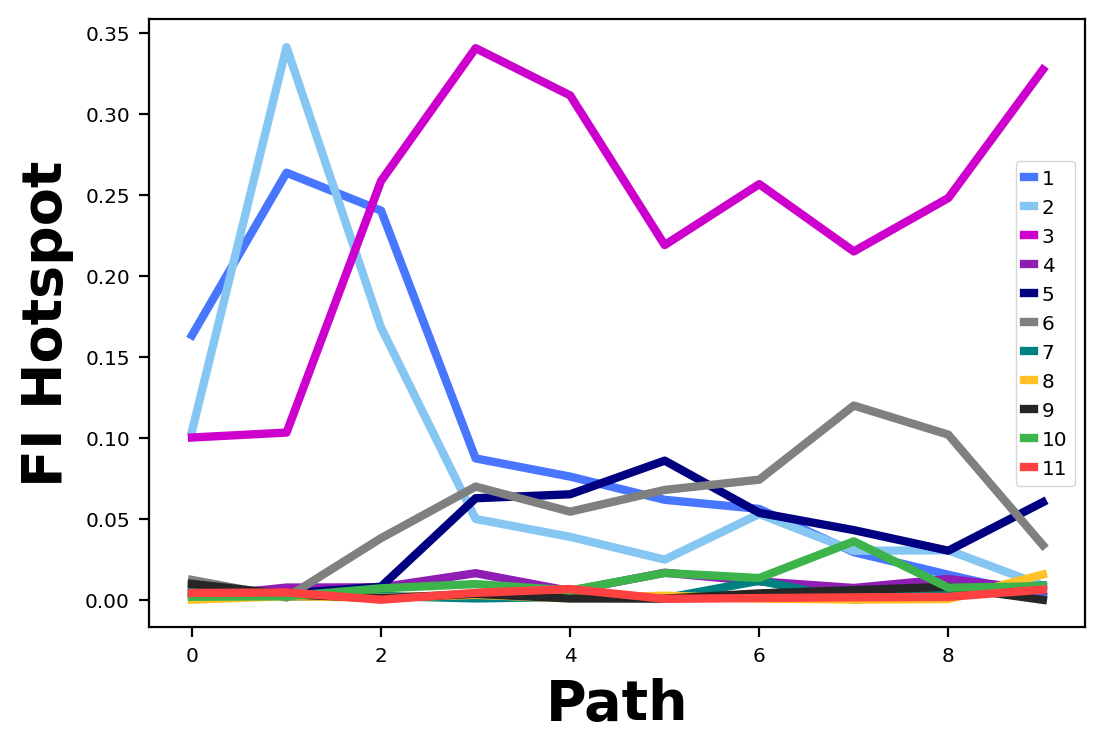

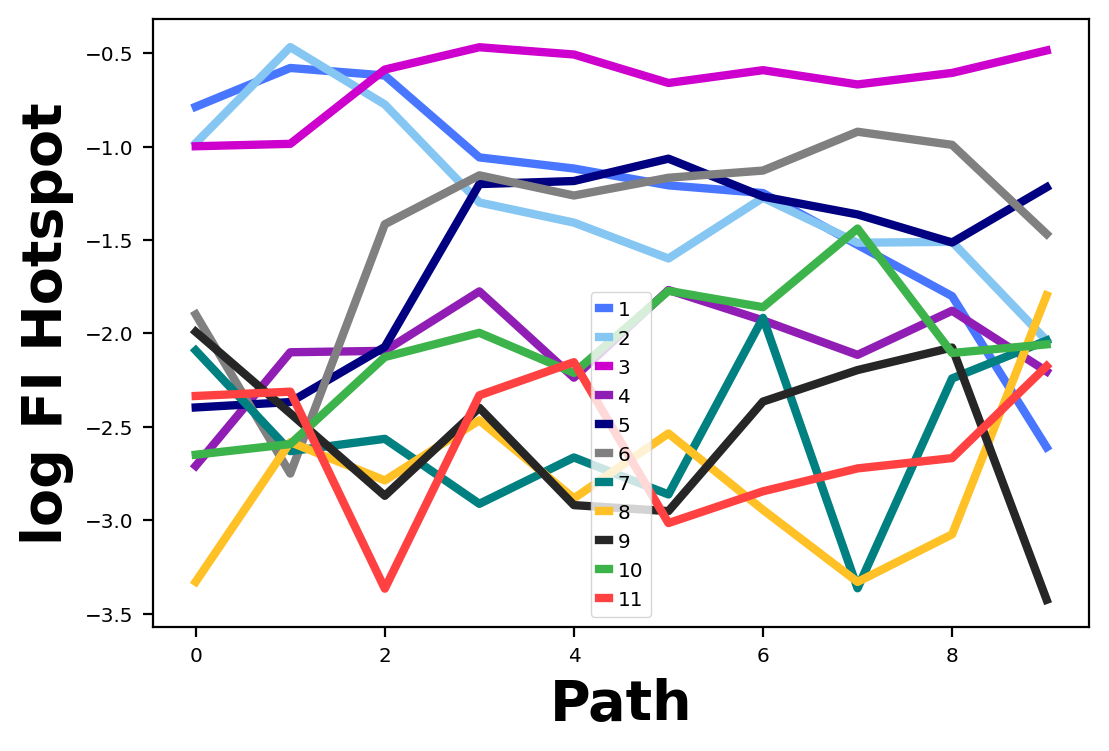

In [31]:
path_Fisher_g = Fisher_g[nearest_indices]
for i in range(path_Fisher_g.shape[1]//2):
    # plt.scatter(np.array(range(path_Fisher_g.shape[0])),path_Fisher_g[:,i,i])
    plt.plot(np.array(range(path_Fisher_g.shape[0])),path_Fisher_g[:,i,i], linewidth=3)
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('FI',fontsize=20,weight='bold')
    plt.savefig(figure_path+f'path_fi.png',dpi=600,bbox_inches='tight')
plt.show()

for i in range(path_Fisher_g.shape[1]//2):
    # plt.scatter(np.array(range(path_Fisher_g.shape[0])),np.log(path_Fisher_g[:,i,i]))
    plt.plot(np.array(range(path_Fisher_g.shape[0])),np.log10(path_Fisher_g[:,i,i]), linewidth=3)
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('FI',fontsize=20,weight='bold')
    plt.savefig(figure_path+f'path_log_fi.png',dpi=600,bbox_inches='tight')
plt.show()

path_Fisher_hs = Fisher_hs[nearest_indices]
for i in range(path_Fisher_hs.shape[1]):
    # plt.scatter(np.array(range(path_Fisher_hs.shape[0])),path_Fisher_hs[:,i,i], label=f'{i+1}')
    plt.plot(np.array(range(path_Fisher_hs.shape[0])),path_Fisher_hs[:,i,i], label=f'{i+1}', linewidth=3)
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('FI Hotspot',fontsize=20,weight='bold')
plt.legend()
plt.savefig(figure_path+f'path_fi_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

for i in range(path_Fisher_hs.shape[1]):
    # plt.scatter(np.array(range(path_Fisher_hs.shape[0])),np.log(path_Fisher_hs[:,i,i]), label=f'{i+1}')
    plt.plot(np.array(range(path_Fisher_hs.shape[0])),np.log10(path_Fisher_hs[:,i,i]), label=f'{i+1}', linewidth=3)
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('log FI Hotspot',fontsize=20,weight='bold')
plt.legend()    
plt.savefig(figure_path+f'path_log_fi_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

对Zebrafish，可以看到FI变化比较主要的是0,1,2,下面单独打印

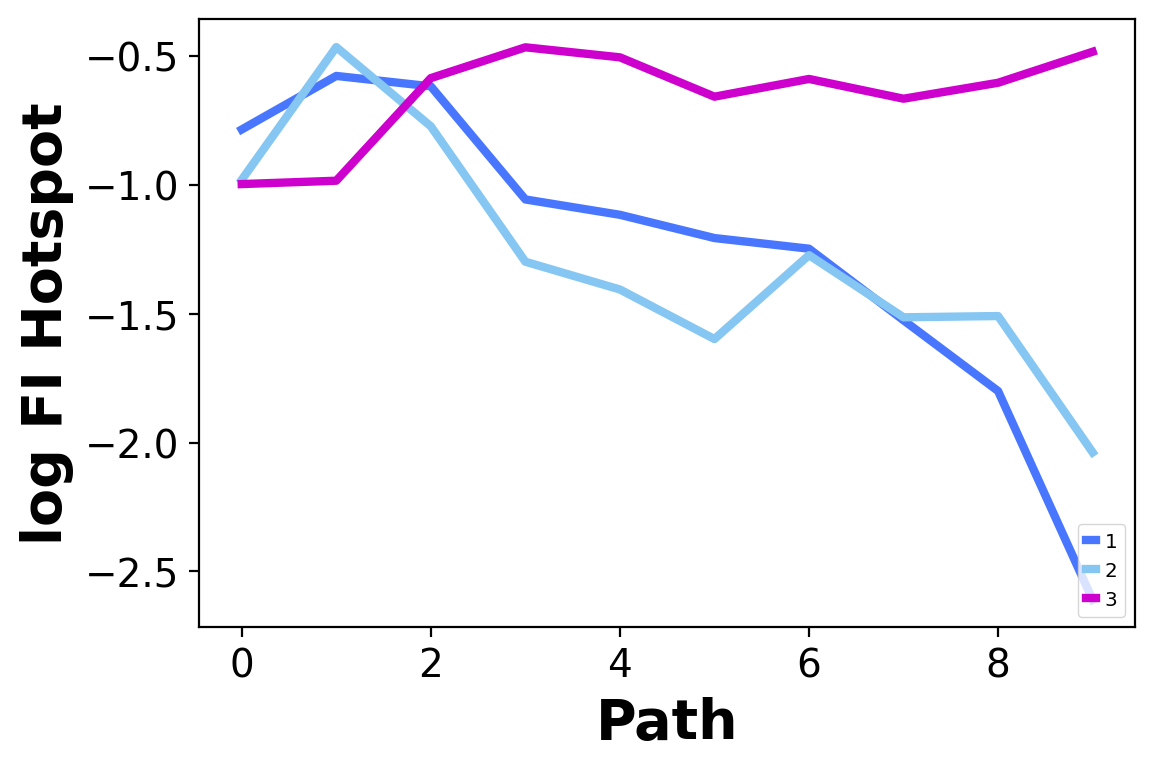

In [32]:
path_Fisher_hs = Fisher_hs[nearest_indices]
for i in [0,1,2]:
    # plt.scatter(np.array(range(path_Fisher_hs.shape[0])),np.log(path_Fisher_hs[:,i,i]), label=f'{i+1}')
    plt.plot(np.array(range(path_Fisher_hs.shape[0])),np.log10(path_Fisher_hs[:,i,i]), label=f'{i+1}', linewidth=3)
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('log FI Hotspot',fontsize=20,weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right') 
plt.savefig(figure_path+f'path_log_fi_hotspot_selected.png',dpi=600,bbox_inches='tight')
plt.show()

Computing scores for 11 modules...


100%|██████████| 11/11 [00:00<00:00, 23.33it/s]


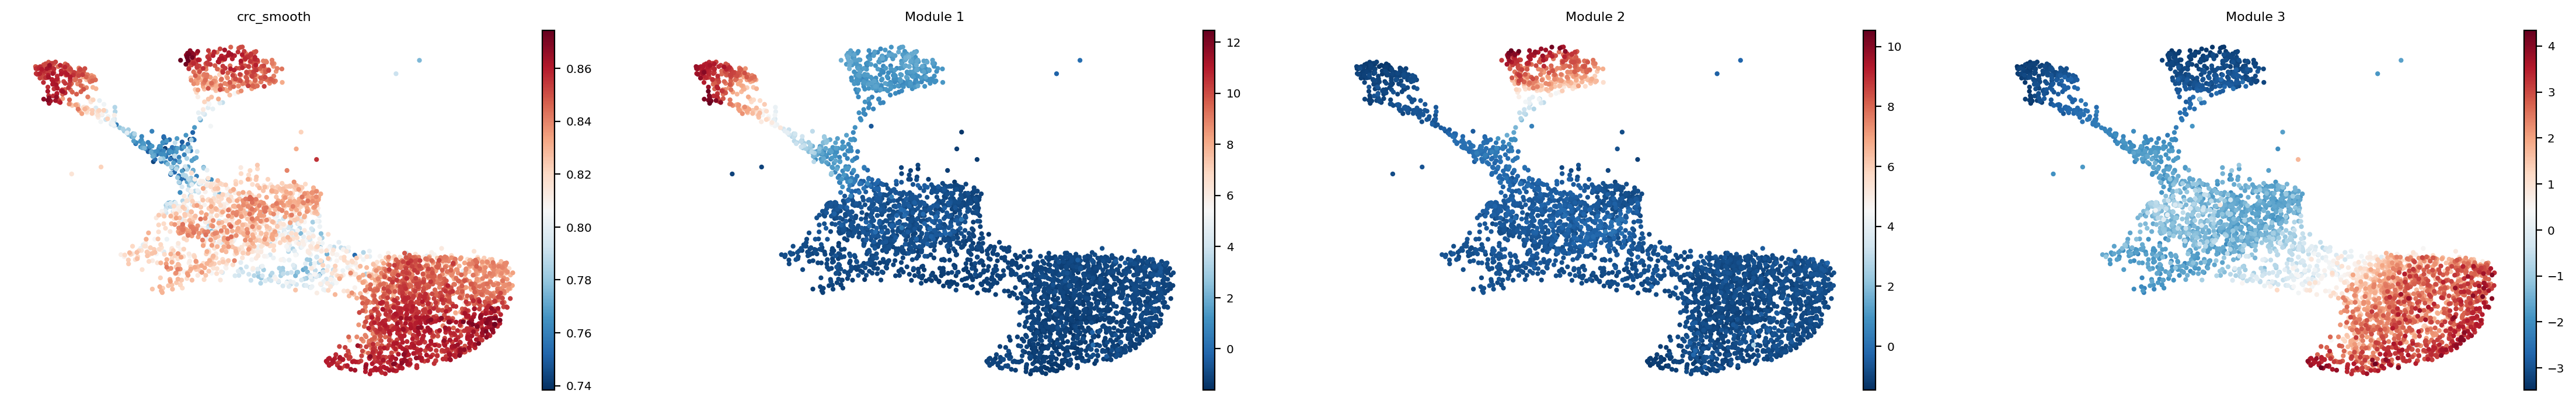

In [33]:
adata.obs['crc_smooth'] = crc_smooth
module_scores = hs.calculate_module_scores()
module_cols = ['crc_smooth']

for c in [1,2,3]:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

fig = sc.pl.umap(adata, color=module_cols, frameon=False, return_fig=True)
fig.savefig(figure_path+f'hotspot_module_score.png',dpi=600,bbox_inches='tight')

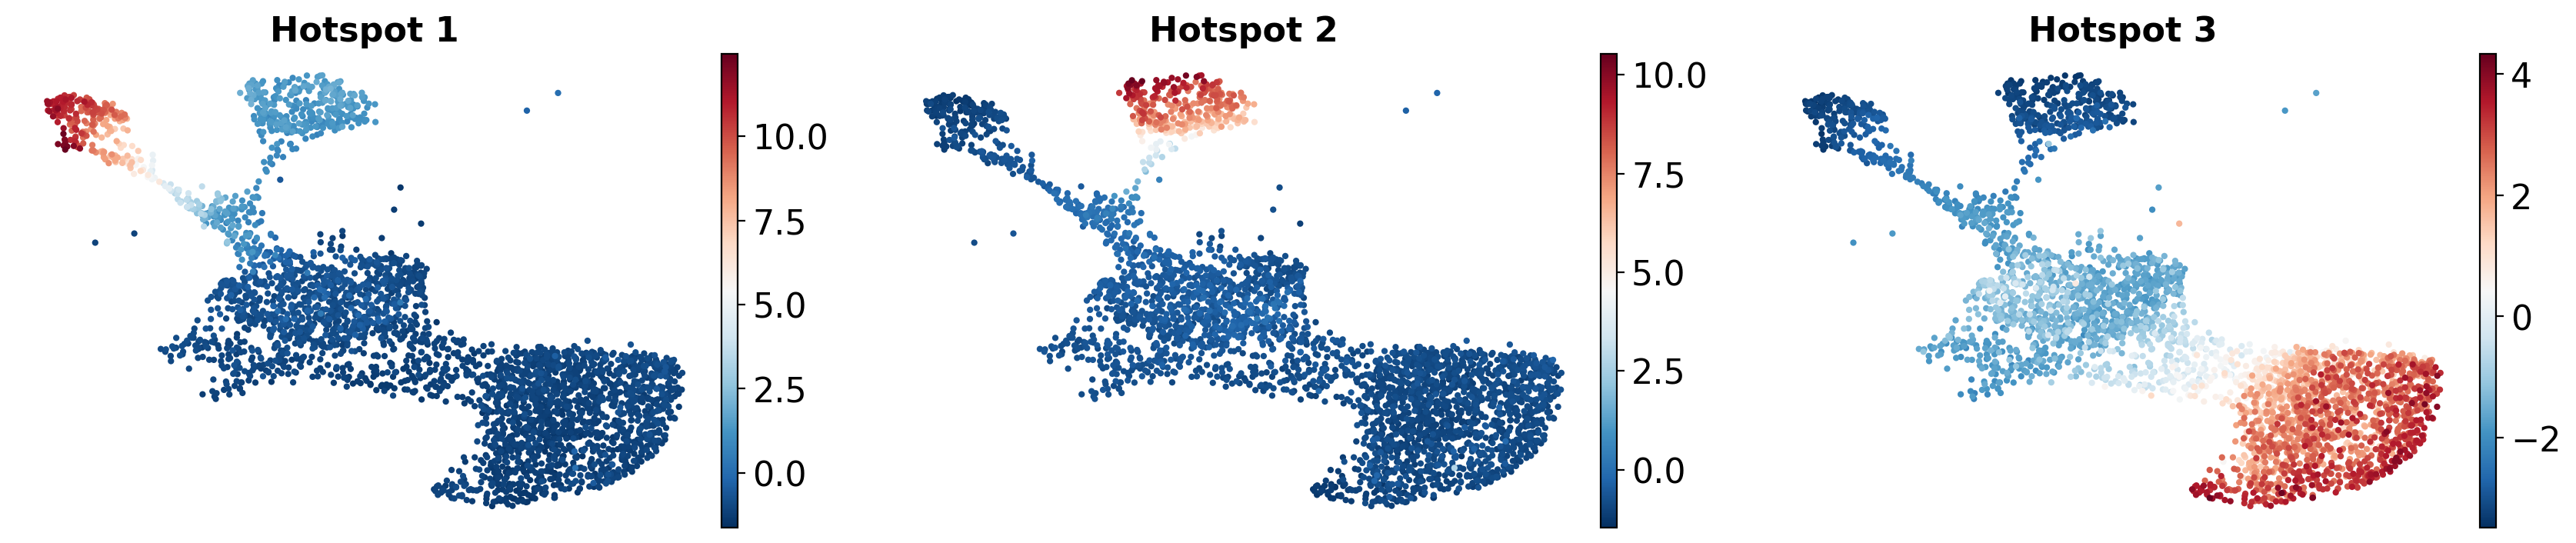

In [34]:
module_cols = []

for c in [1,2,3]:
    key = f"Hotspot {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

adata.obsm['X_plt'] = np.concatenate([np.array([X_plt,]).T, np.array([Y_plt,]).T], axis = 1)
fig = sc.pl.embedding(adata, basis='plt', color=module_cols, frameon=False, return_fig=True)

# 调整标题的字体大小
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=16, fontweight='bold')  # 将标题字体大小设置为 20
    ax.tick_params(labelsize=16)
    
# 显示图像
plt.show()
fig.savefig(figure_path+f'hotspot_module_score.png',dpi=600,bbox_inches='tight')

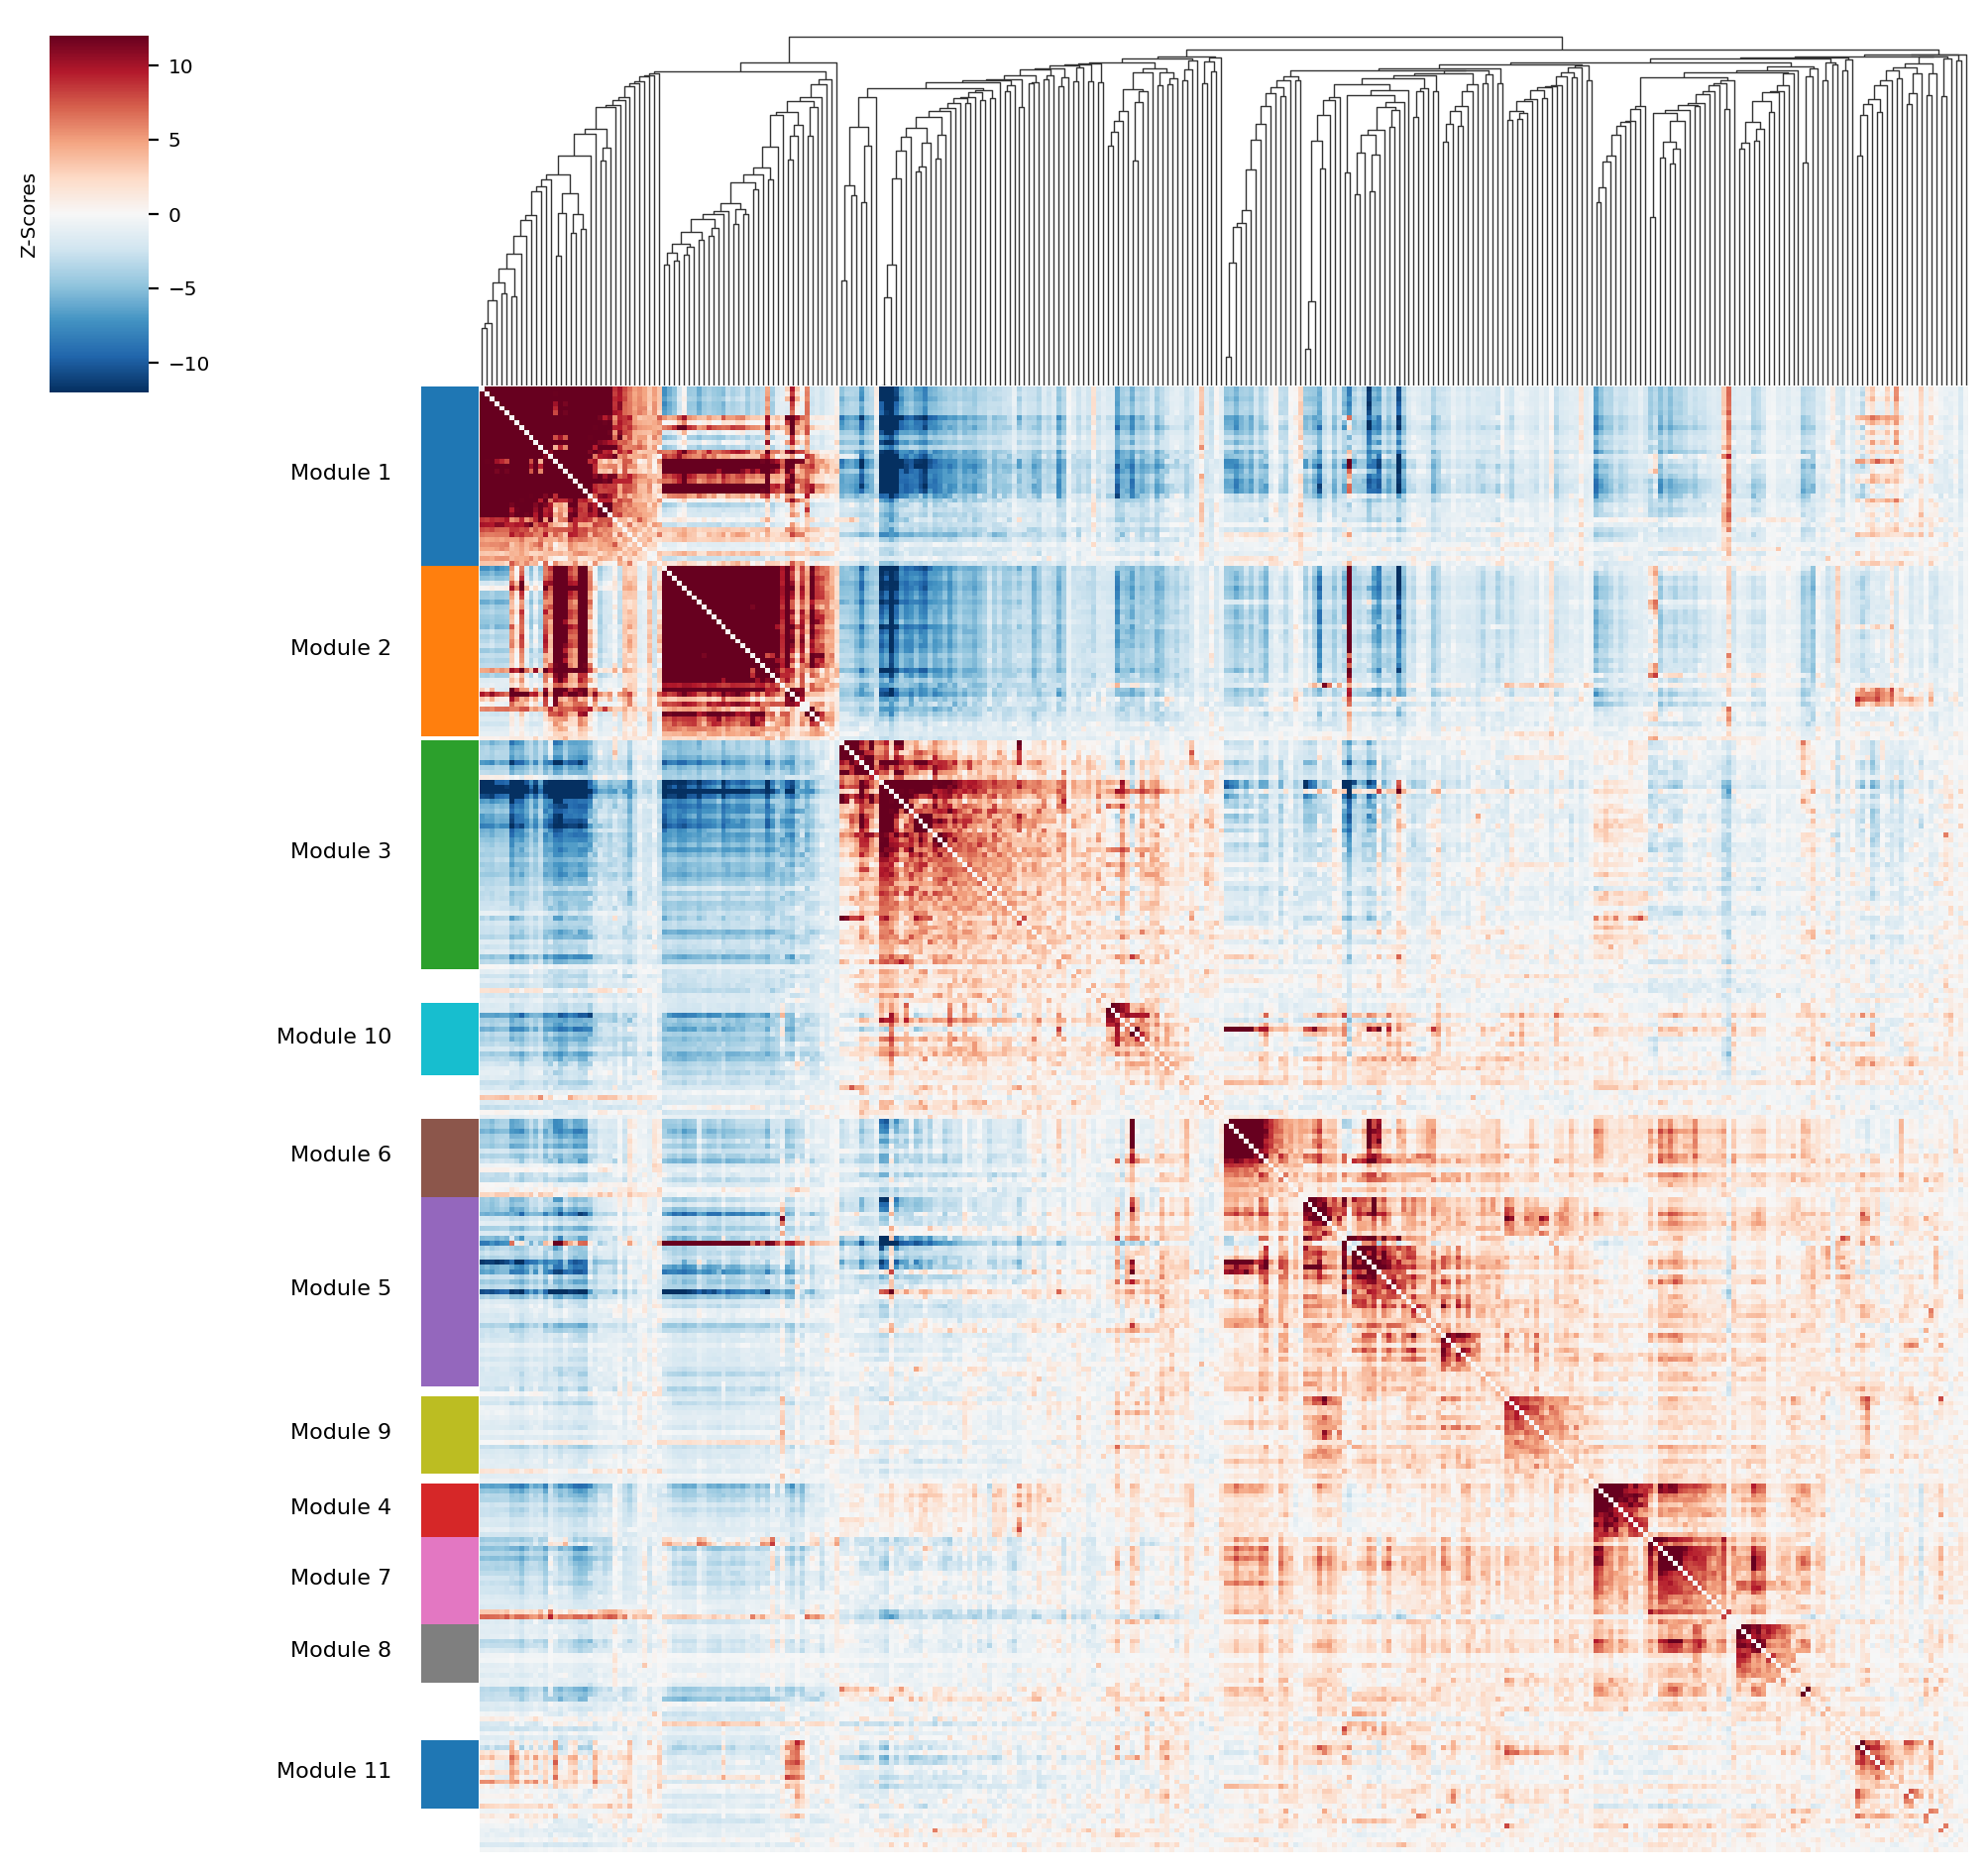

In [35]:
hs.plot_local_correlations(vmin=-12, vmax=12)

In [36]:
g_eig = [0]*path_Fisher_hs.shape[0]
for i in range(path_Fisher_hs.shape[0]):
    g_eig[i] = np.linalg.eigh(path_Fisher_hs[i])

gij_eig = np.array([g_eig[i][0] for i in range(path_Fisher_hs.shape[0])])
gij_eig[np.where(gij_eig<0)] = 0
gij_eig = np.real(gij_eig)

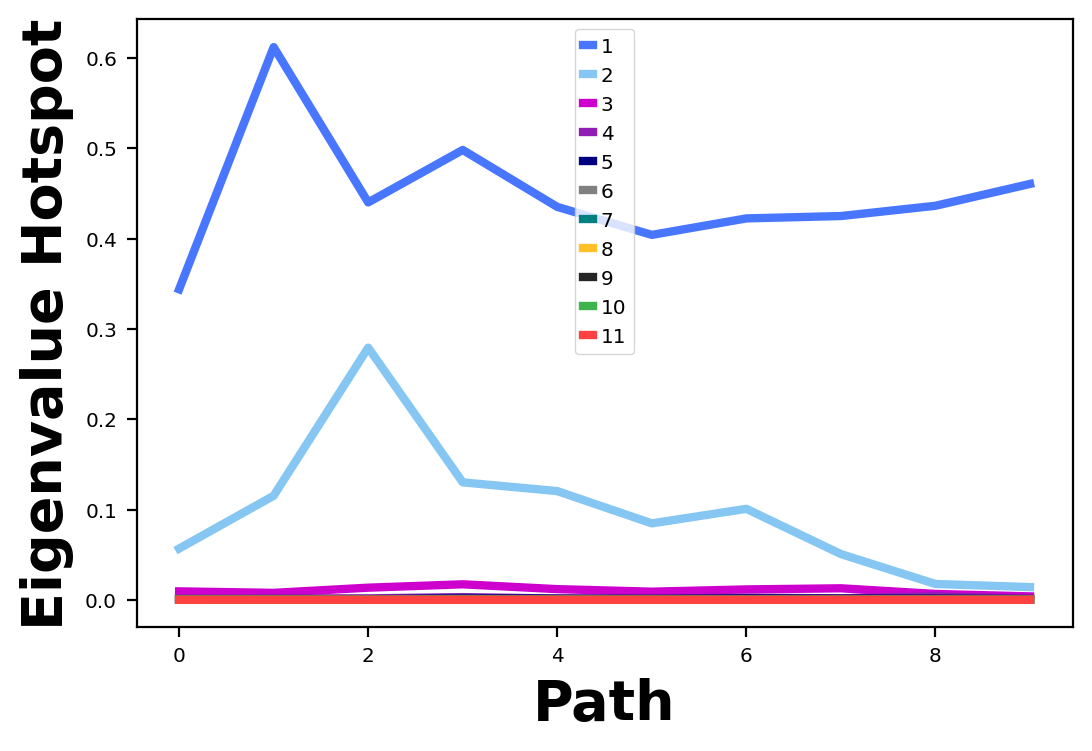

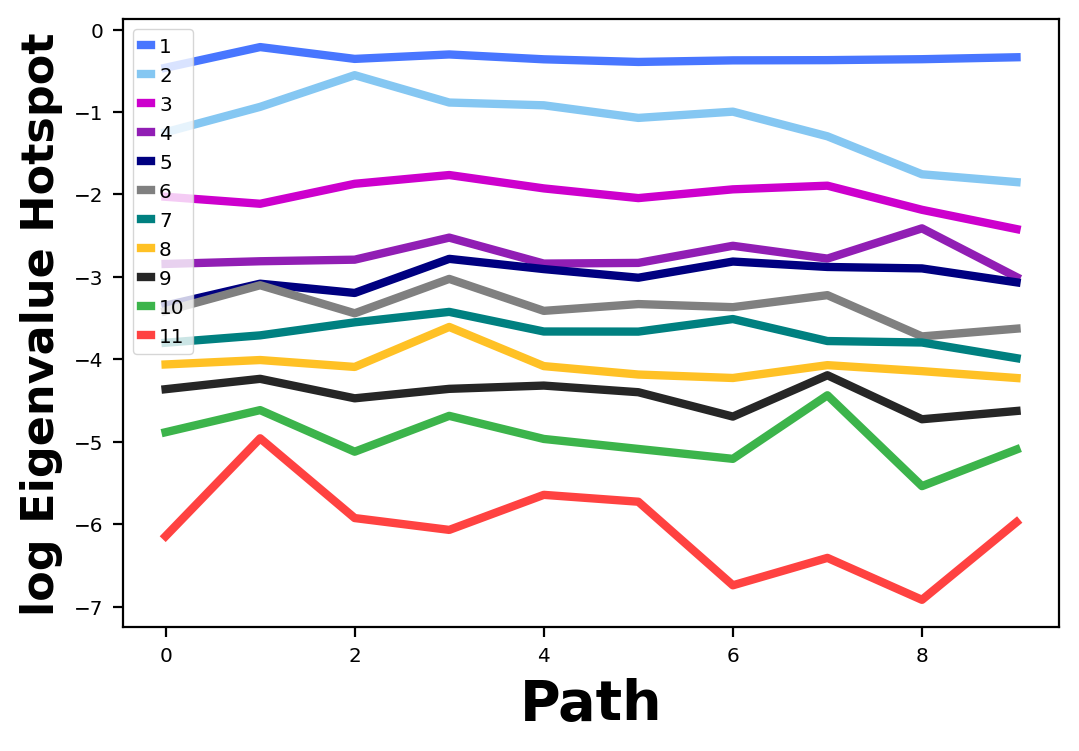

In [37]:
for i in range(path_Fisher_hs.shape[1]):
    # plt.scatter(np.array(range(path_Fisher_hs.shape[0])),gij_eig[:,-(i+1)], label=f'{i+1}')
    plt.plot(np.array(range(path_Fisher_hs.shape[0])),gij_eig[:,-(i+1)], label=f'{i+1}', linewidth=3)
plt.legend()
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('Eigenvalue Hotspot',fontsize=20,weight='bold')
plt.savefig(figure_path+f'path_eigen_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

for i in range(path_Fisher_hs.shape[1]):
    # plt.scatter(np.array(range(path_Fisher_hs.shape[0])),np.log10(gij_eig[:,-(i+1)]), label=f'{i+1}')
    plt.plot(np.array(range(path_Fisher_hs.shape[0])),np.log10(gij_eig[:,-(i+1)]), label=f'{i+1}', linewidth=3)
plt.legend(loc = 'upper left')
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('log Eigenvalue Hotspot',fontsize=16,weight='bold')
plt.savefig(figure_path+f'path_log_eigen_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

## **Sensitivity** ##

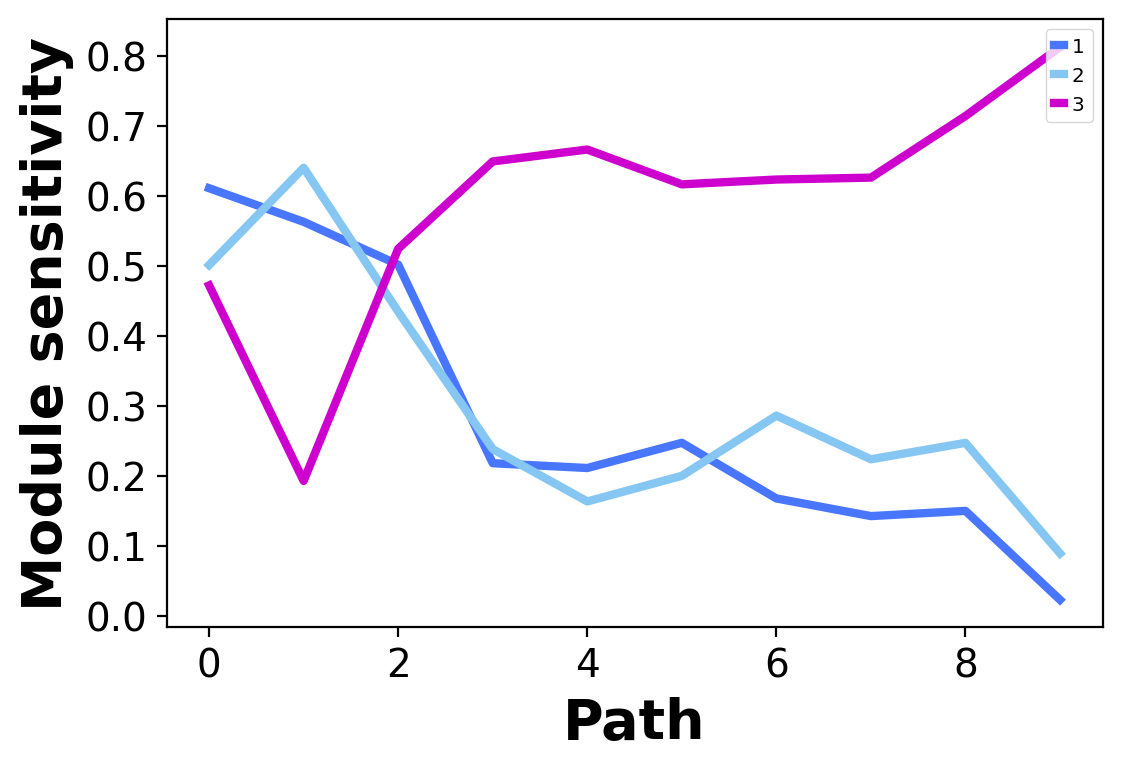

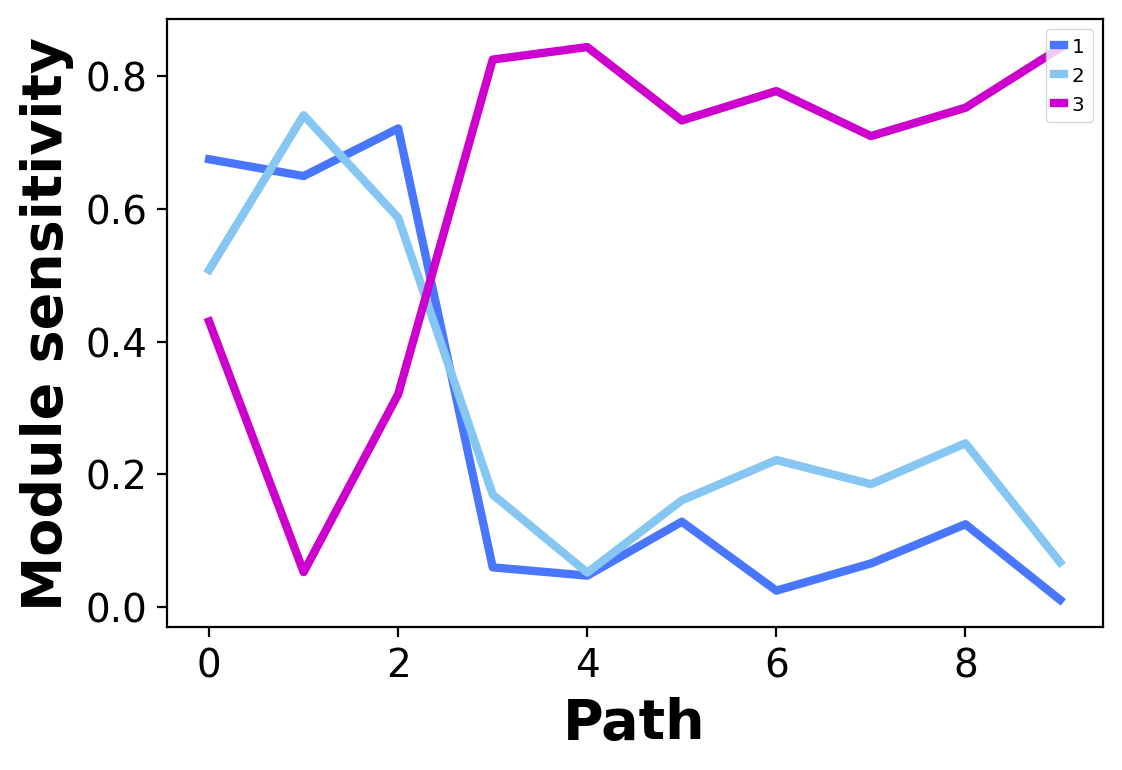

In [38]:
## Weighted sensitivity

for i in range(3):
    sensitivity = np.zeros(path_Fisher_hs.shape[0])
    for k in range(hs_dim):
        sensitivity = sensitivity + np.array([np.abs(g_eig[j][1][i,k]) for j in range(path_Fisher_hs.shape[0])]) * np.array([g_eig[j][0][k] for j in range(path_Fisher_hs.shape[0])])
    sensitivity = sensitivity/np.array([g_eig[j][0].sum() for j in range(path_Fisher_hs.shape[0])])
    plt.plot(sensitivity,label=f'{i+1}', linewidth=3)
plt.legend(loc = 'upper right')
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('Module sensitivity',fontsize=20,weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(figure_path+f'path_sensitivity_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

for i in range(3):
    plt.plot([np.abs(g_eig[j][1][i,-1]) for j in range(path_Fisher_hs.shape[0])],label=f'{i+1}', linewidth=3)
plt.legend(loc = 'upper right')
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('Module sensitivity',fontsize=20,weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(figure_path+f'path_weighted_sensitivity_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

## **Sparsity** ##

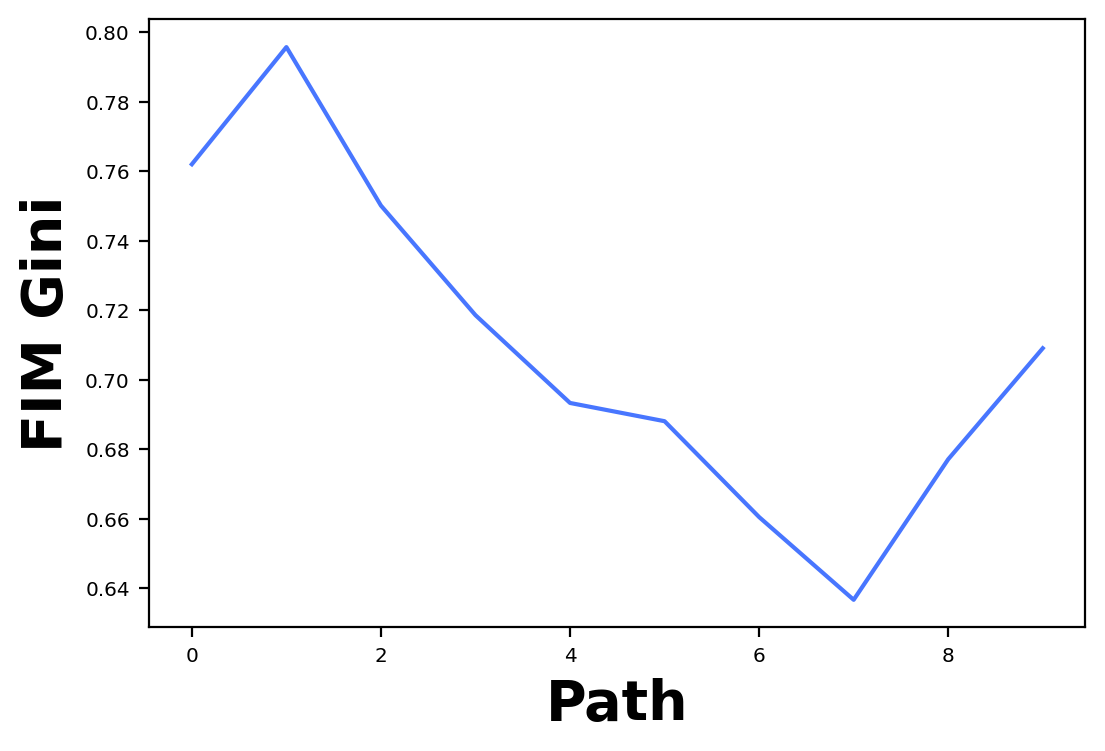

In [39]:
def gini_coefficient(matrix):
    # 将矩阵展平为一维数组
    values = matrix.flatten()
    
    # 排序
    sorted_values = np.sort(values)[::-1]
    
    # 计算 Gini 系数
    n = len(sorted_values)
    cumulative_values = np.cumsum(sorted_values)
    gini = (2 * np.sum(cumulative_values) / np.sum(sorted_values) - (n + 1)) / n
    
    return gini

# gini = [gini_coefficient(np.abs(Fisher_hs[i])) for i in range(Fisher_hs.shape[0])]
plt.plot([gini_coefficient(np.abs(np.mean(Fisher_hs[cell_arr[k],:,:], axis=0))) for k in range(len(cell_arr))])
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('FIM Gini',fontsize=20,weight='bold')
plt.savefig(figure_path+f'path_Gini_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

## **Gene module distribution** ##

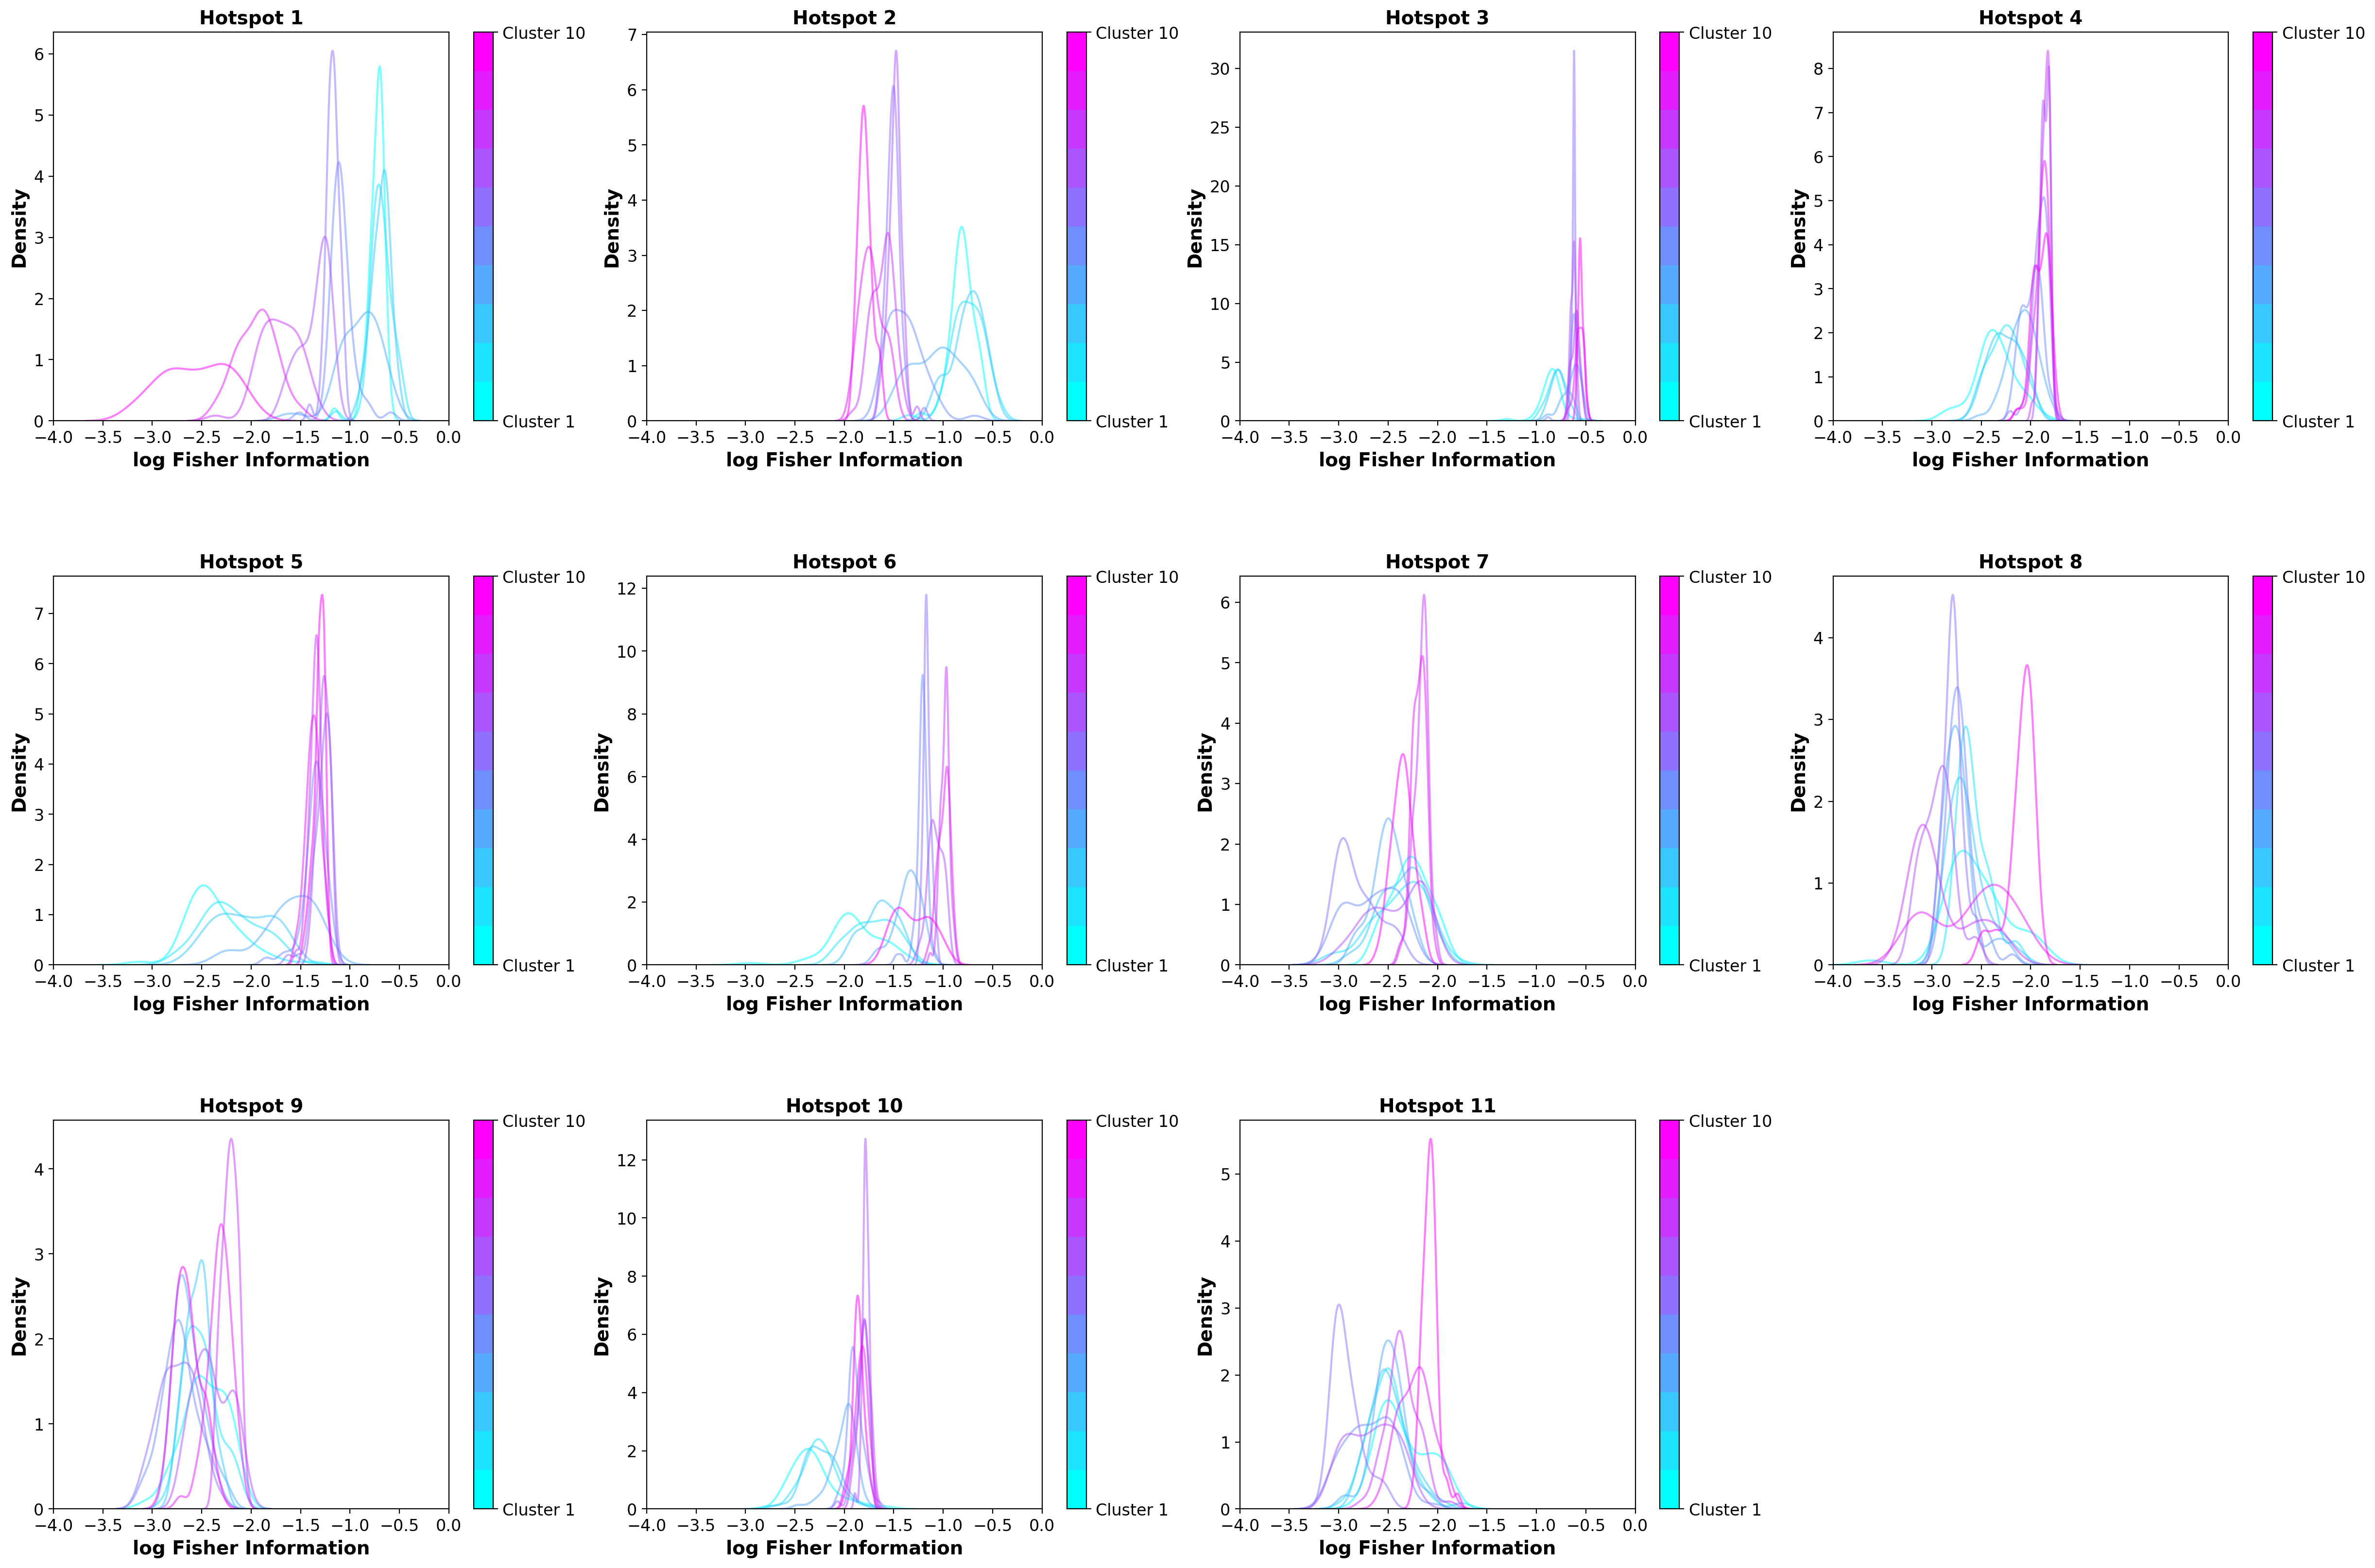

In [40]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch

# 假设 cell_arr 和 Fisher_hs 已经定义
colors = plt.get_cmap('cool')(np.linspace(0, 1, len(cell_arr)))  # 使用 spectral 颜色映射
cmap = ListedColormap(colors)

plt.figure(figsize=(30, 20))

for i in range(Fisher_hs.shape[1]):
    plt.subplot(3,4,i+1)
    color_labels = []

    values = [np.log10((np.abs(smooth_func(Fisher_hs[:, i, i])) + 1e-5)[cell_arr[k]]) for k in range(len(cell_arr))]
    
    for k in range(len(cell_arr)):
        sns.kdeplot(values[k], fill=False, label=f'{k + 1}', alpha=0.5, color=colors[k, :])
        color_labels.append(f'S {k + 1}')

    plt.ylabel('Density', fontsize=14, fontweight='bold')
    plt.xlabel('log Fisher Information', fontsize=14, fontweight='bold')
    plt.title(f'Hotspot {i + 1}', fontsize=14, fontweight='bold')
    # plt.xlim(-9, -2)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-4,0)
    
    norm = Normalize(vmin=0, vmax=len(cell_arr) - 1)  # 设置归一化范围
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # 需要设置一个空数组

    # 添加 colorbar 仅标记开始和结束
    cbar = plt.colorbar(sm, ticks=[0, len(cell_arr) - 1])
    cbar.ax.set_yticklabels([f'Cluster 1', f'Cluster {len(cell_arr)}'], fontsize=12)  # 设置 colorbar 标签

    patches = [Patch(color=colors[k, :], label=f'Class {k + 1}') for k in range(len(cell_arr))]

plt.subplots_adjust(hspace=0.4)
plt.savefig(result_path+f'per dim.png')
plt.show()

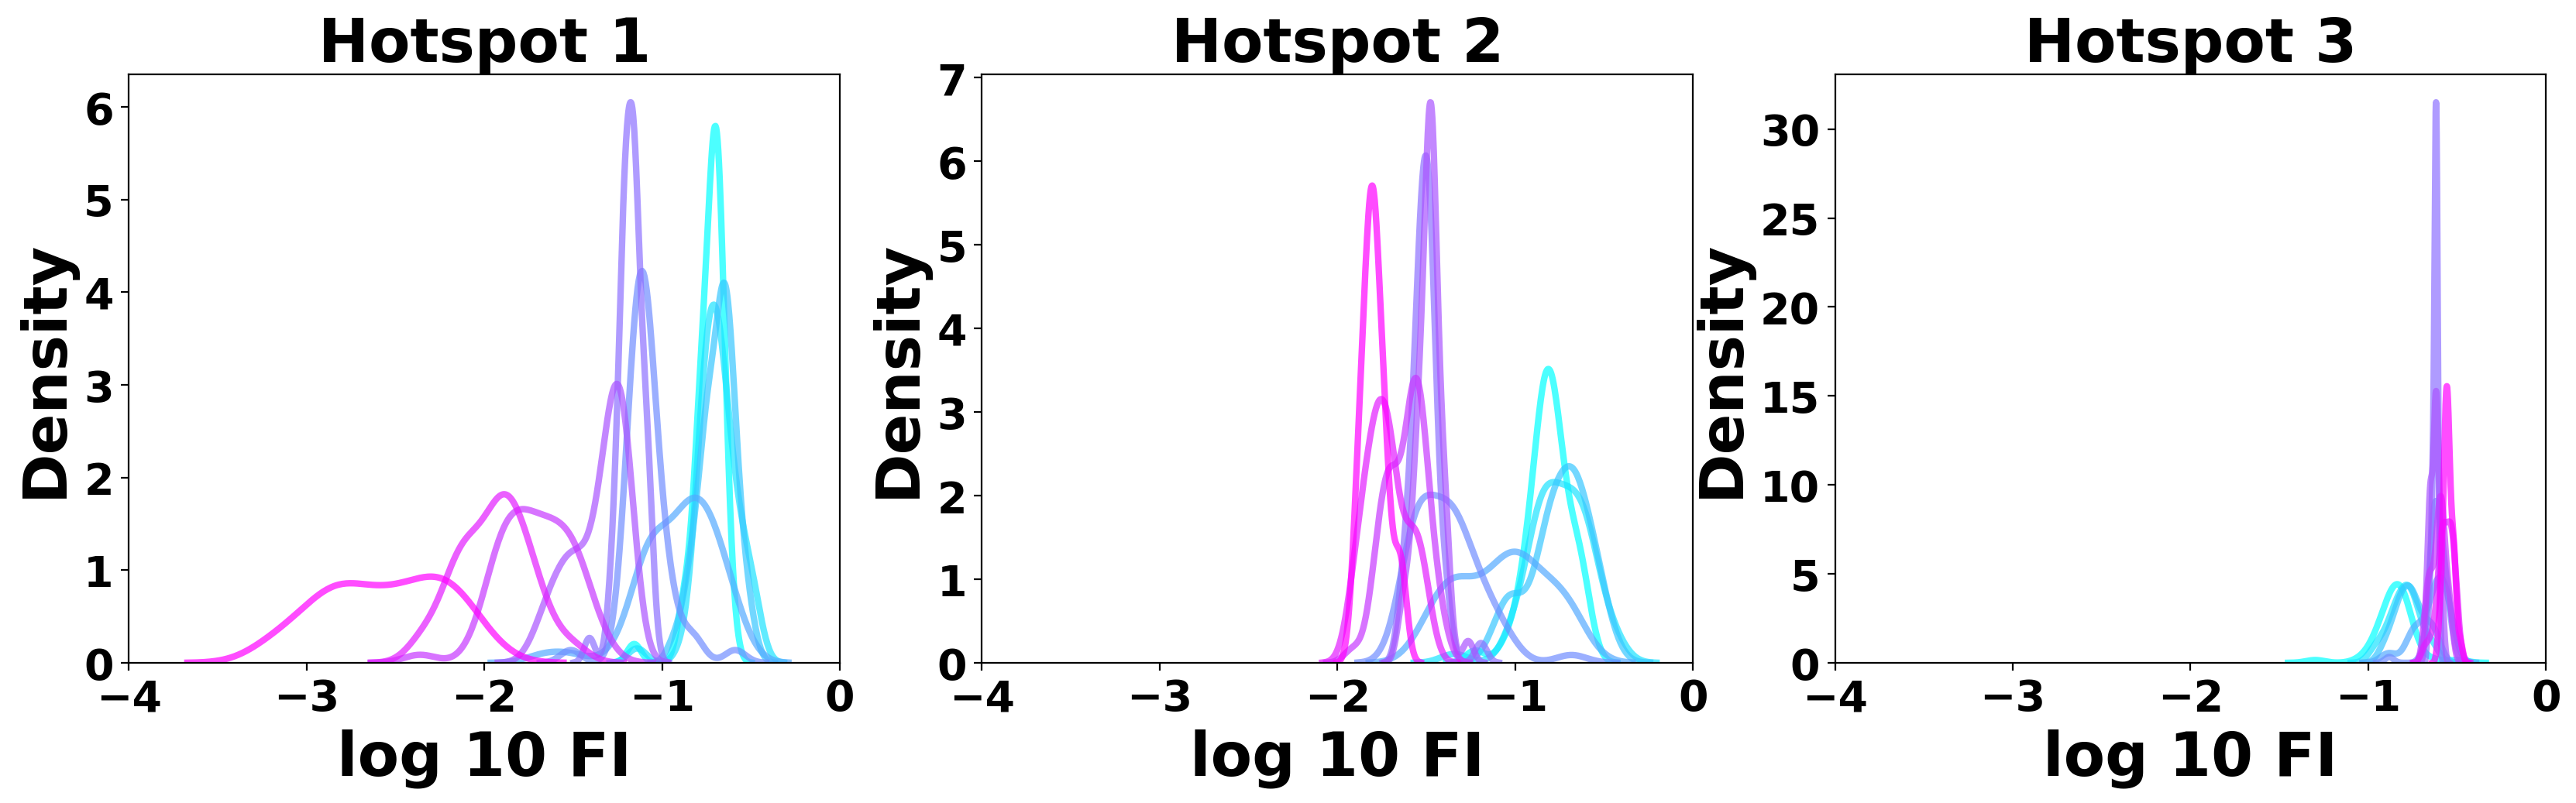

In [50]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch

# 假设 cell_arr 和 Fisher_hs 已经定义
colors = plt.get_cmap('cool')(np.linspace(0, 1, len(cell_arr)))  # 使用 spectral 颜色映射
cmap = ListedColormap(colors)

plt.figure(figsize=(20, 5))

for i in range(3):
    plt.subplot(1,3,i+1)
    color_labels = []

    values = [np.log10((np.abs(smooth_func(Fisher_hs[:, i, i])) + 1e-5)[cell_arr[k]]) for k in range(len(cell_arr))]
    
    for k in range(len(cell_arr)):
        sns.kdeplot(values[k], fill=False, label=f'{k + 1}', alpha=0.7, color=colors[k, :], linewidth=3)
        color_labels.append(f'S {k + 1}')

    plt.ylabel('Density', fontsize=28, fontweight='bold')
    plt.xlabel('log 10 FI', fontsize=28, fontweight='bold')
    plt.title(f'Hotspot {i + 1}', fontsize=28, fontweight='bold')
    # plt.xlim(-9, -2)
    plt.xticks(fontsize=20, fontweight = 'bold', ticks=[-4,-3,-2,-1,0])
    plt.yticks(fontsize=20, fontweight = 'bold')
    plt.xlim(-4,0)
    
    norm = Normalize(vmin=0, vmax=len(cell_arr) - 1)  # 设置归一化范围
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # 需要设置一个空数组

    
    # # 添加 colorbar 仅标记开始和结束
    # cbar = plt.colorbar(sm, ticks=[0, len(cell_arr) - 1])
    # cbar.ax.set_yticklabels([rf'RC = 1', rf'RC = {len(cell_arr)}'], fontweight='bold', fontsize=20)  # 设置 colorbar 标签

    # patches = [Patch(color=colors[k, :], label=f'Class {k + 1}') for k in range(len(cell_arr))]

plt.subplots_adjust(hspace=0.4)
# plt.tight_layout()
plt.savefig(result_path+f'per dim 123.png')
plt.show()

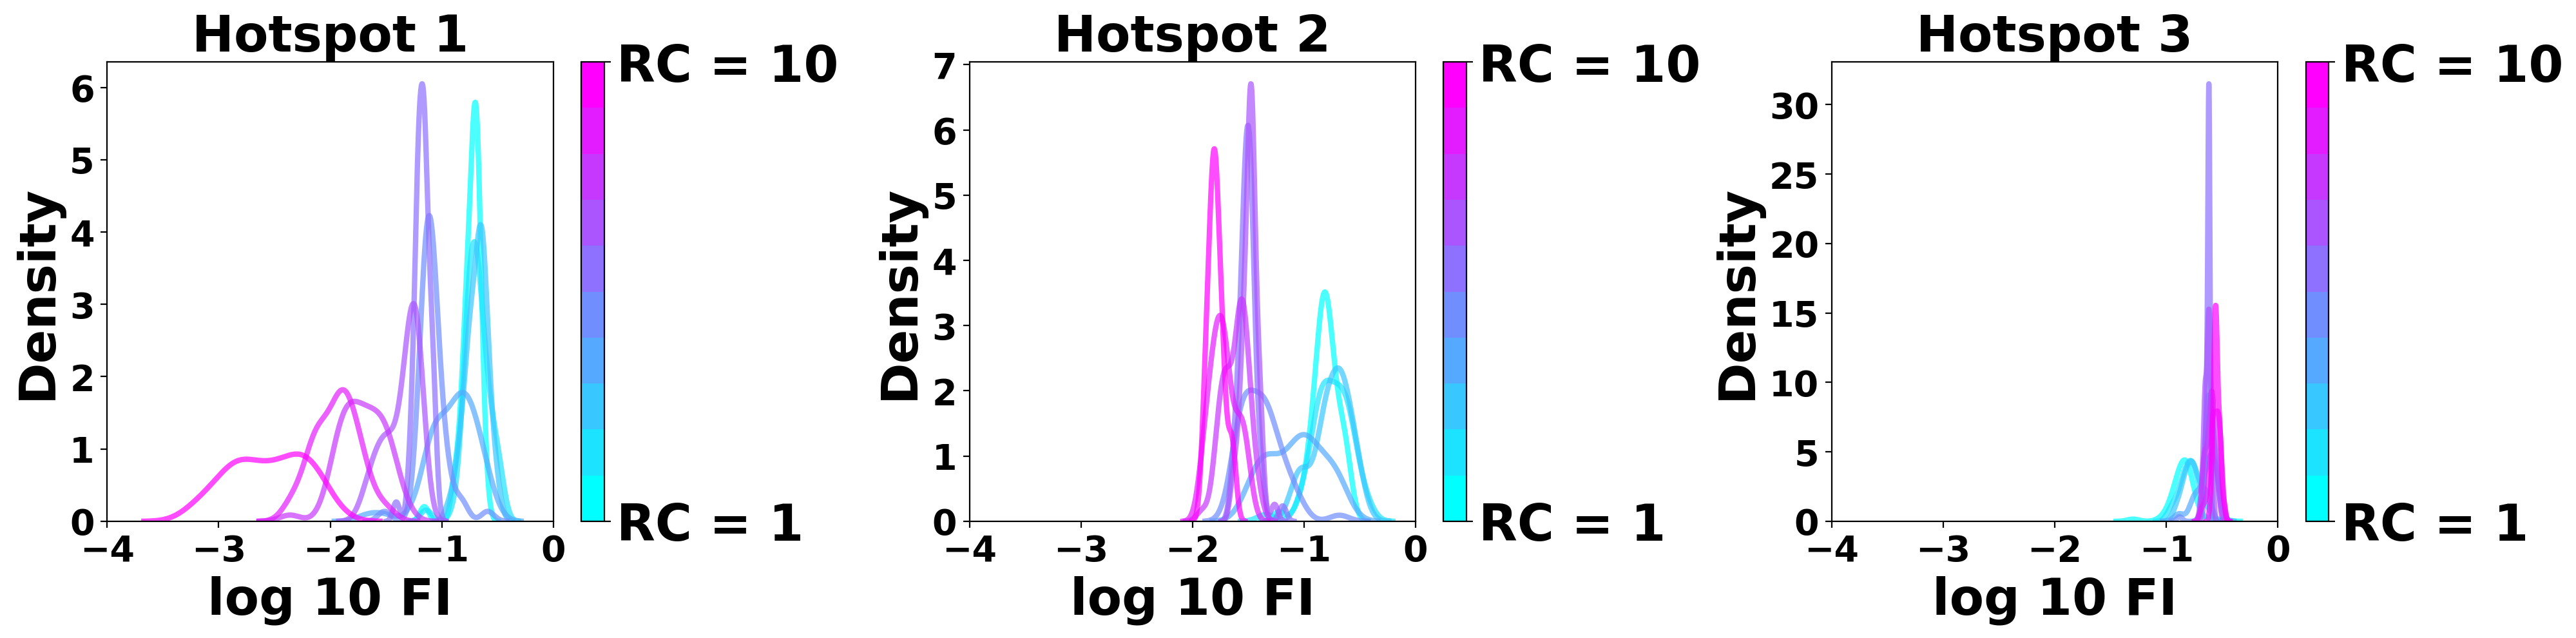

In [53]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch

# 假设 cell_arr 和 Fisher_hs 已经定义
colors = plt.get_cmap('cool')(np.linspace(0, 1, len(cell_arr)))  # 使用 spectral 颜色映射
cmap = ListedColormap(colors)

plt.figure(figsize=(20, 5))

for i in range(3):
    plt.subplot(1,3,i+1)
    color_labels = []

    values = [np.log10((np.abs(smooth_func(Fisher_hs[:, i, i])) + 1e-5)[cell_arr[k]]) for k in range(len(cell_arr))]
    
    for k in range(len(cell_arr)):
        sns.kdeplot(values[k], fill=False, label=f'{k + 1}', alpha=0.7, color=colors[k, :], linewidth=3)
        color_labels.append(f'S {k + 1}')

    plt.ylabel('Density', fontsize=28, fontweight='bold')
    plt.xlabel('log 10 FI', fontsize=28, fontweight='bold')
    plt.title(f'Hotspot {i + 1}', fontsize=28, fontweight='bold')
    # plt.xlim(-9, -2)
    plt.xticks(fontsize=20, fontweight = 'bold', ticks=[-4,-3,-2,-1,0])
    plt.yticks(fontsize=20, fontweight = 'bold')
    plt.xlim(-4,0)
    
    norm = Normalize(vmin=0, vmax=len(cell_arr) - 1)  # 设置归一化范围
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # 需要设置一个空数组

    
    # 添加 colorbar 仅标记开始和结束
    cbar = plt.colorbar(sm, ticks=[0, len(cell_arr) - 1])
    cbar.ax.set_yticklabels([rf'RC = 1', rf'RC = {len(cell_arr)}'], fontweight='bold', fontsize=28)  # 设置 colorbar 标签

    patches = [Patch(color=colors[k, :], label=f'Class {k + 1}') for k in range(len(cell_arr))]

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig(result_path+f'per dim 123 with cbar.png')
plt.show()